In [167]:
%pip install torchvision
%reset -f

DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [168]:
import torchvision.datasets as ds
from torchvision import transforms
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import pickle
from torch.utils.data import random_split, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

np.random.seed(40)

In [169]:
class Optimizer_Adam:
    def __init__(self,epsilon=1e-8,beta1=0.9,beta2=0.999):
        self.epsilon = epsilon
        self.bias_m = None
        self.bias_v = None
        self.beta1 = beta1
        self.beta2 = beta2
        self.weight_m = None
        self.weight_v = None
        self.time = 0
        

    def initialize(self,bias_shape,weight_shape):
        self.bias_m = np.zeros(bias_shape)
        self.bias_v = np.zeros(bias_shape)
        self.weight_m = np.zeros(weight_shape)
        self.weight_v = np.zeros(weight_shape)
        self.time = 0

    def update(self,bias,weight,gradient_bias,gradient_weight,l_rate):
        if self.weight_m is None:
            self.initialize(bias.shape,weight.shape)
        self.time += 1
        self.bias_m = self.beta1 * self.bias_m + (1 - self.beta1) * gradient_bias
        self.bias_v = self.beta2 * self.bias_v + (1 - self.beta2) * (gradient_bias**2)
        self.weight_m = self.beta1 * self.weight_m + (1 - self.beta1) * gradient_weight
        self.weight_v = self.beta2 * self.weight_v + (1 - self.beta2) * (gradient_weight**2)
        m_hat_bias = self.bias_m / (1 - self.beta1**self.time)
        v_hat_bias = self.bias_v / (1 - self.beta2**self.time)
        m_hat_weight = self.weight_m / (1 - self.beta1**self.time)
        v_hat_weight = self.weight_v / (1 - self.beta2**self.time)
        bias = bias - l_rate * m_hat_bias / (np.sqrt(v_hat_bias) + self.epsilon)
        weight = weight - l_rate * m_hat_weight / (np.sqrt(v_hat_weight) + self.epsilon)
       
        return bias,weight

In [170]:
class Dense_Layer:
    def __init__(self,input_dim,output_dim):
        self.bias = np.zeros((output_dim,1))
        self.optimizer = Optimizer_Adam()
        self.weight = np.random.randn(output_dim,input_dim)
        self.weight = self.weight * np.sqrt(2.0/input_dim)
        

    def forward(self,input):
        self.input = input
        temp = np.dot(self.weight,input) + self.bias
        return temp

    def backward(self,l_rate,gradient_output):
        gradient_input = np.dot(self.weight.T,gradient_output)
        n = gradient_output.shape[1]
        gradient_weight = np.dot(gradient_output,self.input.T) / n
        gradient_bias = np.reshape(np.mean(gradient_output,axis=1),(gradient_output.shape[0],1))
        # self.weight = self.weight - l_rate * gradient_weight
        # self.bias = self.bias - l_rate * gradient_bias
        self.bias,self.weight = self.optimizer.update(self.bias,self.weight,gradient_bias,gradient_weight,l_rate)
        return gradient_input
    def parameters_get(self):
        return self.bias,self.weight

In [171]:
class activationFunction_ReLU:
    def __init__(self):
        self.input = None
        self.output = None
        self.optimizer = None

    def forward(self,input):
        self.input = input
      
        return np.maximum(0,input)

    def backward(self,l_rate,gradient_output):
        
        return gradient_output * (self.input > 0)

In [172]:
class Soft_Max:
    def __init__(self):
        self.input = None
        self.output = None
        self.optimizer = None

    def forward(self,input):
        self.input = input
        exps = np.exp(input - np.max(input,axis=0,keepdims=True))
        return exps / np.sum(exps,axis=0)

    def backward(self,l_rate,gradient_output):
        return gradient_output

In [173]:
class Drop_Out:
    def __init__(self,p):
        self.p = p
        self.mask = None
        self.input = None
        self.output = None


    def forward(self,x):
        self.input = x
        self.mask = (np.random.rand(*x.shape) > self.p).astype(float)

        if(self.p == 1):

            self.output = np.zeros(x.shape)
            return self.output
        elif(self.p == 0):
            self.output = x
            return x
        temp = (1 - self.p)
        self.output = np.multiply(x,self.mask) / temp
        return self.output
    def backward(self,l_rate,gradient_output):
        temp = (1 - self.p)
        return (gradient_output * self.mask) / temp
    


In [174]:
def CrossEntropyLoss(target,prediction):
    temp = np.log(1e-8 + prediction) * target
    return -np.sum(temp)/prediction.shape[1]

In [175]:

class Batch_Normalization:
    def __init__(self,input_dim):
        self.epsilon = 1e-8
        self.input = None
        self.output = None
        # self.gamma = np.random.randn(input_dim,1)
        # self.beta = np.random.randn(input_dim,1)
        self.gamma = np.ones((input_dim,1))
        self.beta = np.zeros((input_dim,1))


    def forward(self,x):
        self.input = x
        self.mean = np.mean(x,axis=1,keepdims=True)
        self.var = np.var(x,axis=1,keepdims=True)
        temp2 = self.var + self.epsilon
        self.x_hat = (x - self.mean) / np.sqrt(temp2)

        temp = self.gamma * self.x_hat
        return temp + self.beta

    def backward(self,l_rate,gradient_output):
        temp = self.input - self.mean
        temp2 = self.var + self.epsilon
        grad_x_hat = gradient_output * self.gamma
        var_gradient = np.sum(grad_x_hat * (temp) * -0.5 * np.power(temp2, -1.5), axis=0)
        mean_gradient = np.sum(grad_x_hat * -1 / np.sqrt(temp2), axis=0)
        mean_gradient += var_gradient * np.mean(-2 * (temp), axis=0)
        input_gradient = grad_x_hat / np.sqrt(temp2)
        input_gradient += var_gradient * 2 * (temp) / gradient_output.shape[0]
        input_gradient += mean_gradient / gradient_output.shape[0]
        gamma_gradient = np.sum(gradient_output * self.x_hat, axis=1, keepdims=True)
        self.gamma = self.gamma - l_rate * gamma_gradient
        beta_gradient = np.sum(gradient_output, axis=1, keepdims=True)
        self.beta = self.beta -  l_rate * beta_gradient

        return input_gradient

In [176]:
def Prediction(fnn,x):
    result =x
    for layer in fnn:
        result = layer.forward(result)
    return result


In [177]:
transform = transforms.ToTensor()
train_data = ds.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = ds.FashionMNIST(root='./data', train=False, download=True, transform=transform) 


In [178]:
ratio_train = 0.85

total = len(train_data)
train_size = int(total * ratio_train)
val_size = total - train_size

set_train , set_valid = random_split(train_data, [train_size, val_size])


In [179]:

fnn = [
    Dense_Layer(784,1024),
    Batch_Normalization(1024),
    activationFunction_ReLU(),
    Dense_Layer(1024,10),
    Soft_Max()
]

In [180]:

# fnn = [
#     Dense_Layer(784,128),
#     Batch_Normalization(128),
#     activationFunction_ReLU(),
#     Dense_Layer(128,64),
#     Batch_Normalization(64),
#     activationFunction_ReLU(),

#     Dense_Layer(64,10),
#     Soft_Max()
# ]

In [181]:

# fnn = [
#     Dense_Layer(784,1024),
#     Batch_Normalization(1024),
#     activationFunction_ReLU(),
#     Dense_Layer(1024,256),
#     Batch_Normalization(256),
#     activationFunction_ReLU(),
#     Drop_Out(0.5),
#     Dense_Layer(256,64),
#     Batch_Normalization(64),
#     activationFunction_ReLU(),
#     Dense_Layer(64,10),
#     Soft_Max()
# ]

In [182]:
rate_learning = 0.001
epochs = 20
batch_size = 256

In [183]:
loader_train = DataLoader(set_train, batch_size=batch_size, shuffle=True)
loader_valid = DataLoader(set_valid, batch_size=val_size, shuffle=True)
loader_test = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

In [184]:
image_valid, label_valid = next(iter(loader_valid))

In [185]:
image_valid = image_valid.view(image_valid.shape[0], -1).numpy().T
one_hot_valid = np.zeros((10, image_valid.shape[1]))
for i in range(image_valid.shape[1]):
    one_hot_valid[label_valid[i]- 1, i] = 1

In [186]:
image_test, label_test = next(iter(loader_test))

image_test = image_test.view(image_test.shape[0], -1).numpy().T
one_hot_test = np.zeros((10, image_test.shape[1]))
for i in range(image_test.shape[1]):
    one_hot_test[label_test[i]- 1, i] = 1



In [187]:
arr_train_loss = []
arr_valid_loss = []
arr_train_accuracy = []
arr_valid_accuracy = []
arr_f1 = []

for epoch in range(epochs):
    train_loss = 0
    prediction = []
    true_label = []

    for batch in tqdm(loader_train):
        image, label = batch
        image = image.view(image.shape[0], -1).numpy().T
        one_hot = np.zeros((10, image.shape[1]))
        for i in range(image.shape[1]):
            one_hot[label[i]-1, i] = 1

        result = Prediction(fnn, image)

        prediction.append(np.argmax(result, axis=0))
        true_label.append(np.argmax(one_hot, axis=0))
        loss = CrossEntropyLoss(one_hot, result)
        train_loss += loss
        gradient_result = result - one_hot
        for l in reversed(fnn):
            gradient_result = l.backward(rate_learning, gradient_result)
    train_loss /= len(loader_train)
    prediction = np.concatenate(prediction) 
    true_label = np.concatenate(true_label)
    train_accuracy = accuracy_score(true_label, prediction) 
    arr_train_loss.append(train_loss)
    arr_train_accuracy.append(train_accuracy)
    print("epoch : {}".format(epoch+1))
    print("Loss : {:.2f},Train Accuracy : {:.2f}".format(train_loss, train_accuracy))
    #---------------------------------Validation---------------------------------
    result = Prediction(fnn, image_valid)

    valid_loss = CrossEntropyLoss(one_hot_valid, result)
    arr_valid_loss.append(valid_loss)
    temp = np.argmax(result, axis=0)
    temp2 = np.argmax(one_hot_valid, axis=0)
    valid_accuracy = accuracy_score(temp2, temp)
    arr_valid_accuracy.append(valid_accuracy)   
    valid_f1 = f1_score(temp2, temp, average='macro')
    arr_f1.append(valid_f1)
    print("Valid accuracy: {:.2f},Valid F1: {:.2f}".format(valid_accuracy, valid_f1))


#---------------------------------Test---------------------------------
result = image_test
for l in fnn:
    result = l.forward(result)
test_loss = CrossEntropyLoss(one_hot_test, result)
temp = np.argmax(result, axis=0)

temp2 = np.argmax(one_hot_test, axis=0)
test_accuracy = accuracy_score(temp2, temp)
test_f1 = f1_score(temp2, temp, average='macro')
print("Test Accuracy: {:.3f}".format(test_accuracy))
print("F1: {:.3f}".format(test_f1))
print("Test Loss: {:.3f}".format(test_loss))

cm_test = confusion_matrix(temp2, temp)


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:56<00:00,  3.55it/s]


epoch : 1
Loss : 0.67, Accuracy : 0.79
accuracy: 0.84, F1: 0.84


100%|██████████| 200/200 [00:55<00:00,  3.58it/s]


epoch : 2
Loss : 0.45, Accuracy : 0.85
accuracy: 0.86, F1: 0.86


100%|██████████| 200/200 [01:10<00:00,  2.85it/s]


epoch : 3
Loss : 0.39, Accuracy : 0.86
accuracy: 0.87, F1: 0.86


100%|██████████| 200/200 [01:04<00:00,  3.12it/s]


epoch : 4
Loss : 0.36, Accuracy : 0.87
accuracy: 0.87, F1: 0.87


100%|██████████| 200/200 [00:58<00:00,  3.39it/s]


epoch : 5
Loss : 0.34, Accuracy : 0.88
accuracy: 0.87, F1: 0.87


100%|██████████| 200/200 [01:00<00:00,  3.28it/s]


epoch : 6
Loss : 0.32, Accuracy : 0.89
accuracy: 0.88, F1: 0.88


100%|██████████| 200/200 [01:00<00:00,  3.31it/s]


epoch : 7
Loss : 0.30, Accuracy : 0.89
accuracy: 0.88, F1: 0.88


100%|██████████| 200/200 [01:00<00:00,  3.29it/s]


epoch : 8
Loss : 0.29, Accuracy : 0.90
accuracy: 0.88, F1: 0.88


100%|██████████| 200/200 [01:01<00:00,  3.24it/s]


epoch : 9
Loss : 0.28, Accuracy : 0.90
accuracy: 0.88, F1: 0.88


100%|██████████| 200/200 [01:01<00:00,  3.24it/s]


epoch : 10
Loss : 0.27, Accuracy : 0.90
accuracy: 0.88, F1: 0.88


100%|██████████| 200/200 [01:02<00:00,  3.23it/s]


epoch : 11
Loss : 0.26, Accuracy : 0.91
accuracy: 0.89, F1: 0.89


100%|██████████| 200/200 [01:05<00:00,  3.05it/s]


epoch : 12
Loss : 0.25, Accuracy : 0.91
accuracy: 0.88, F1: 0.88


100%|██████████| 200/200 [01:17<00:00,  2.57it/s]


epoch : 13
Loss : 0.24, Accuracy : 0.91
accuracy: 0.89, F1: 0.89


100%|██████████| 200/200 [00:59<00:00,  3.34it/s]


epoch : 14
Loss : 0.24, Accuracy : 0.91
accuracy: 0.88, F1: 0.88


100%|██████████| 200/200 [01:00<00:00,  3.30it/s]


epoch : 15
Loss : 0.23, Accuracy : 0.92
accuracy: 0.89, F1: 0.89


100%|██████████| 200/200 [01:00<00:00,  3.33it/s]


epoch : 16
Loss : 0.22, Accuracy : 0.92
accuracy: 0.89, F1: 0.89


100%|██████████| 200/200 [00:59<00:00,  3.34it/s]


epoch : 17
Loss : 0.21, Accuracy : 0.92
accuracy: 0.88, F1: 0.88


100%|██████████| 200/200 [00:59<00:00,  3.35it/s]


epoch : 18
Loss : 0.20, Accuracy : 0.93
accuracy: 0.89, F1: 0.89


100%|██████████| 200/200 [00:59<00:00,  3.37it/s]


epoch : 19
Loss : 0.20, Accuracy : 0.93
accuracy: 0.88, F1: 0.88


100%|██████████| 200/200 [00:59<00:00,  3.34it/s]


epoch : 20
Loss : 0.19, Accuracy : 0.93
accuracy: 0.89, F1: 0.89
Test Accuracy: 0.877
F1: 0.878
Test Loss: 0.363


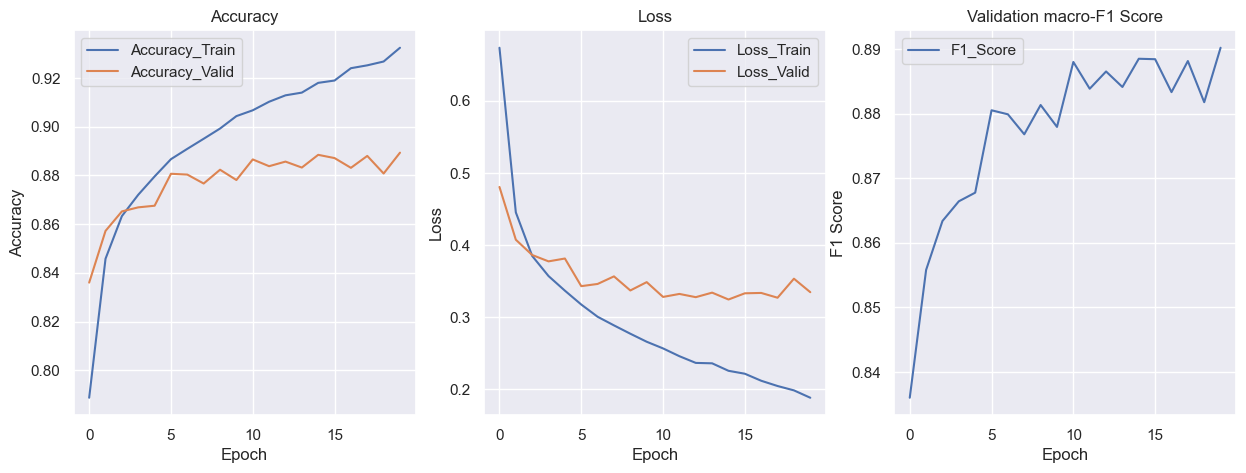

In [188]:
#plot graph
Figure , (x1,x2,x3) = plt.subplots(1,3,figsize=(15,5))
x1.plot(arr_train_accuracy,label='Accuracy_Train')
x1.plot(arr_valid_accuracy,label='Accuracy_Valid')  
x1.set_title('Accuracy')
x1.set_ylabel('Accuracy')
x1.set_xlabel('Epoch')
x1.legend()

x2.plot(arr_train_loss,label='Loss_Train')  
x2.plot(arr_valid_loss,label='Loss_Valid')
x2.set_title('Loss')
x2.set_ylabel('Loss')
x2.set_xlabel('Epoch')
x2.legend()

x3.plot(arr_f1,label='F1_Score')
x3.set_title('Validation macro-F1 Score')
x3.set_ylabel('F1 Score')
x3.set_xlabel('Epoch')
x3.legend()
plt.savefig('1905038_Acc_loss.png')
plt.show()


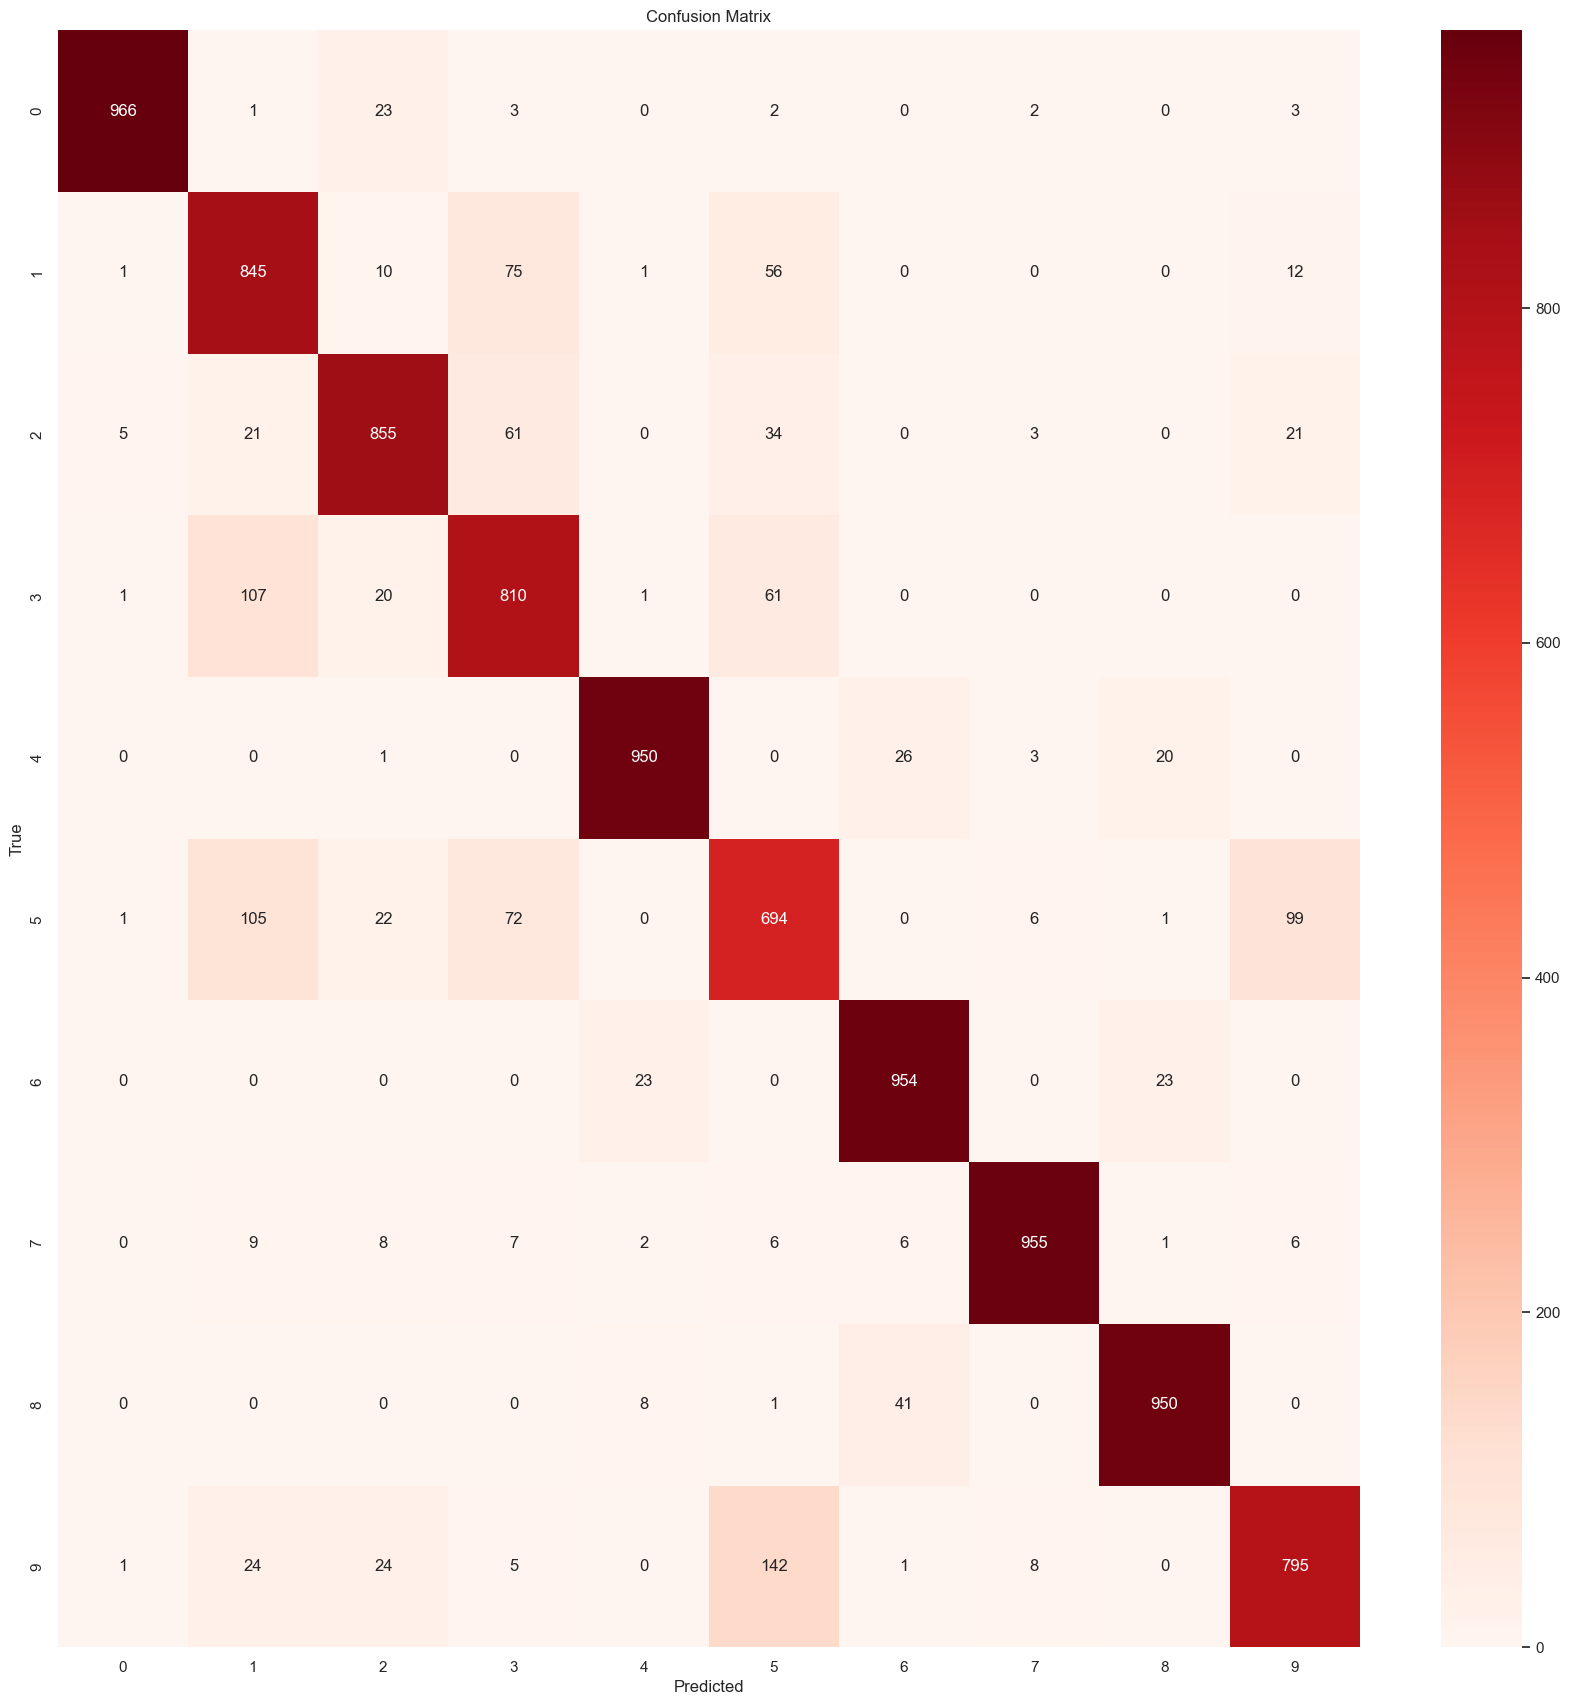

In [189]:
#plot confusion matrix
# cm_test = confusion_matrix(temp2, temp)
sns.set_theme()
plt.figure(figsize=(21,21))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('1905038_CM.png')
plt.show()

In [190]:
weight = []
bias = []
epsilon = []
gamma = []
beta = []
for l in fnn:
    if isinstance(l,Dense_Layer):
        b,w = l.parameters_get()
        weight.append(w)
        bias.append(b)
    if isinstance(l,Batch_Normalization):
        gamma.append(l.gamma)
        beta.append(l.beta)
        epsilon.append(l.epsilon)

with open('1905038_Model.pickle', 'wb') as f:
    pickle.dump([weight,bias,gamma,beta,epsilon], f)
f.close()



In [191]:

fnn = [
    Dense_Layer(784,1024),
    Batch_Normalization(1024),
    activationFunction_ReLU(),
    Dense_Layer(1024,10),
    Soft_Max()
]

In [192]:
with open('1905038_Model.pickle','rb') as f:
    params = pickle.load(f)
weight,bias,gamma,beta,epsilon = params

idx = 0
idx2 = 0
j=0
while j < len(fnn):
    if isinstance(fnn[j],Dense_Layer):
        fnn[j].bias = bias[idx]
        fnn[j].weight = weight[idx]
        idx += 1
    if isinstance(fnn[j],Batch_Normalization):
        fnn[j].gamma = gamma[idx2]
        fnn[j].beta = beta[idx2]
        fnn[j].epsilon = epsilon[idx2]
        idx2 += 1
    j += 1



In [193]:
test_data_2 = ds.FashionMNIST(root='./data', train=False, download=True, transform=transform) 

loader_test_2 = DataLoader(test_data_2, batch_size=len(test_data_2), shuffle=False)


In [194]:
image_test, label_test = next(iter(loader_test_2))

image_test = image_test.view(image_test.shape[0], -1).numpy().T
one_hot_test = np.zeros((10, image_test.shape[1]))
for i in range(image_test.shape[1]):
    one_hot_test[label_test[i]- 1, i] = 1

In [195]:
result = image_test


for l in fnn:
    result = l.forward(result)


Prediction = np.argmax(result, axis=0)

test_true = np.argmax(one_hot_test, axis=0)
test_accuracy = accuracy_score(test_true, Prediction)
test_f1 = f1_score(test_true, Prediction, average='macro')
print("Test Accuracy: {:.3f}, F1 Score: {:.3f}".format(test_accuracy, test_f1))

Test Accuracy: 0.877, F1 Score: 0.878
